<a href="https://colab.research.google.com/github/NikolDrongova/M7DataSP/blob/main/Cats_in_the_wild_Finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.1 MB/s eta 0:00:00


In [2]:
import timm
import os

import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json

import torch
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

from fastai.vision.all import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Dataset - 10 Big cats of the world**
https://www.kaggle.com/datasets/gpiosenka/cats-in-the-wild-image-classification

In [17]:
DATASET = 'gpiosenka/cats-in-the-wild-image-classification'
ZIP_PATH = './cats-in-the-wild-image-classification.zip'
IMAGES_PATH = './train'

In [18]:
os.environ['KAGGLE_USERNAME'] = 'evaklimentov'
os.environ['KAGGLE_KEY'] = 'c3161c890c8b21e1e5cba18c9a7505c0'

!kaggle datasets download -d {DATASET} -p ./

cats-in-the-wild-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
import zipfile

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall('./')

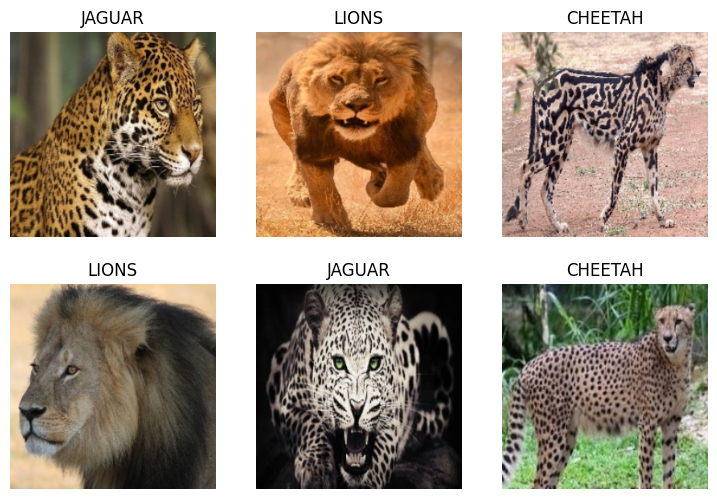

In [30]:
images = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256, method='squish'))

dls = images.dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=6)

In [31]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))

1872
467


## Load ConvNeXt model and fine-tune it

In [32]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.354605,0.299171,0.907923,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.249312,0.169613,0.957173,01:20
1,0.187398,0.158813,0.961456,01:20
2,0.137873,0.150560,0.970021,01:21
3,0.104904,0.142693,0.970021,01:21


## See how our model performs:


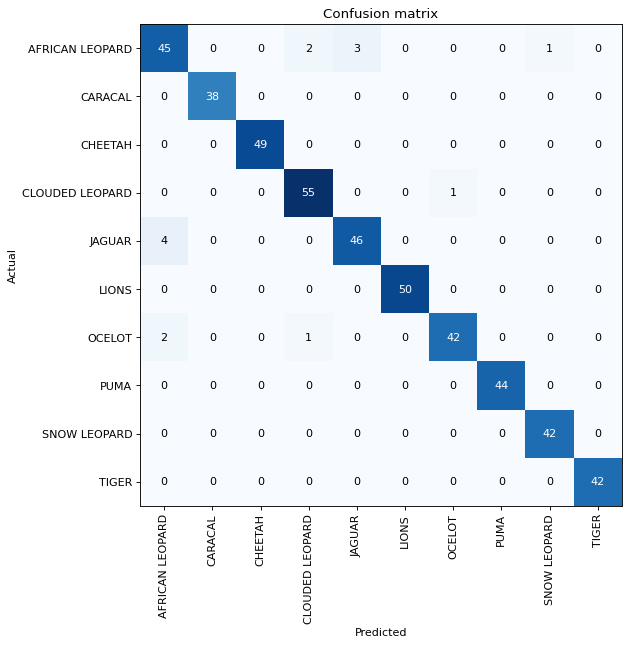

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

### what is hard to predic?

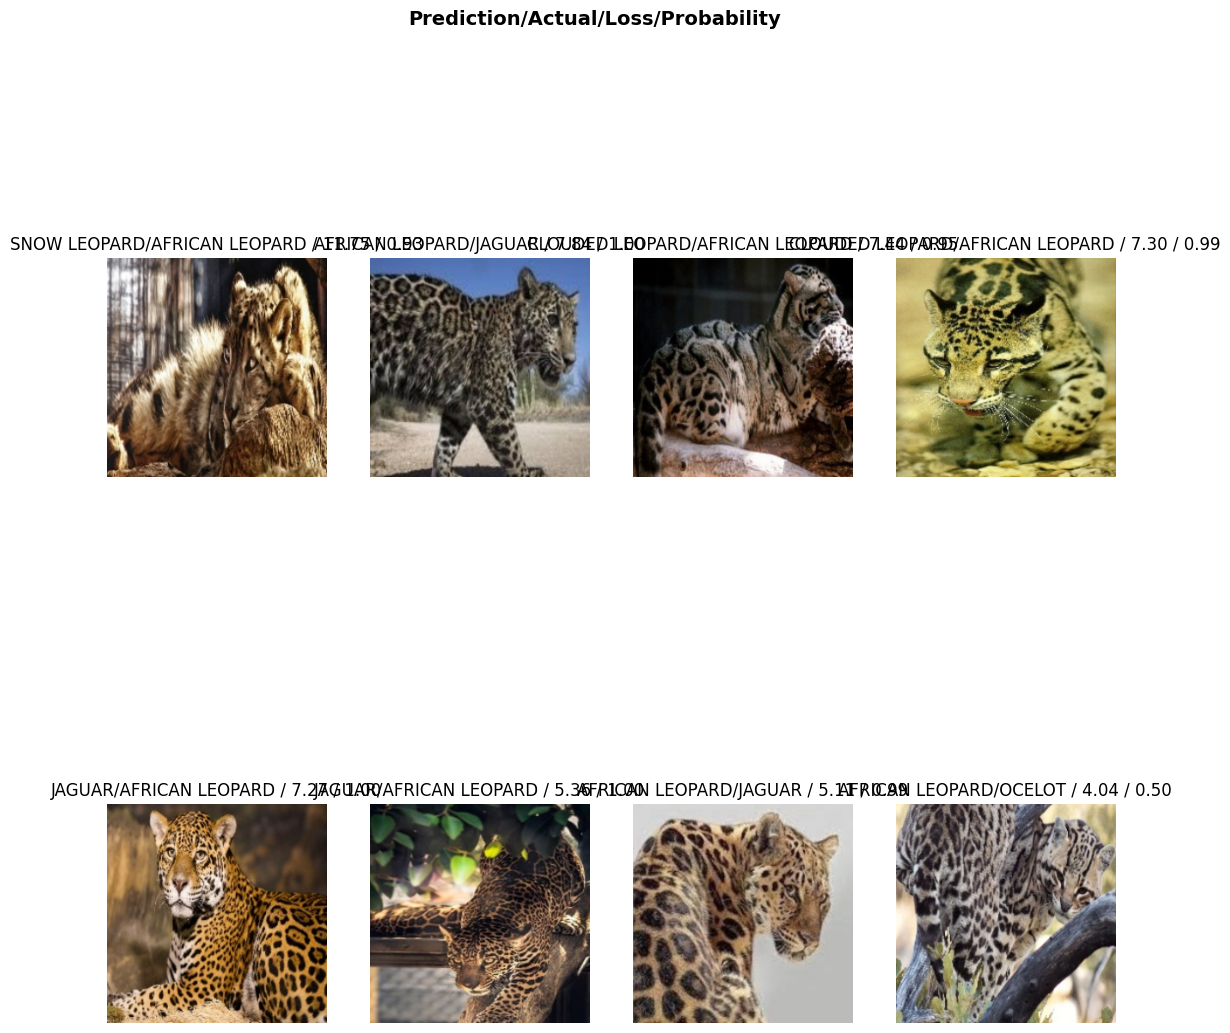

In [24]:
interp.plot_top_losses(8, figsize=(13,13))

# **Data** **augmentation**

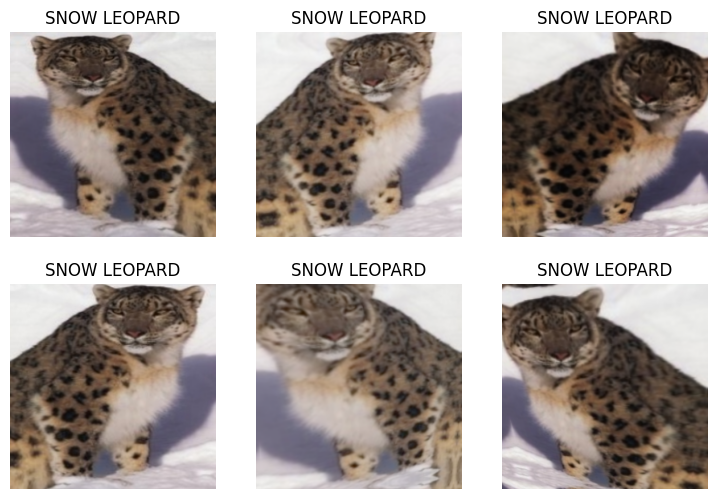

In [35]:
tfms = [Rotate(), Zoom(), Warp(), Brightness(), Flip(), Contrast()]

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=tfms
).dataloaders(IMAGES_PATH, bs=64)

dls.show_batch(max_n=10, unique=True)

In [36]:
learn = vision_learner(dls, convnext_tiny, metrics=accuracy)
learn.fine_tune(3, freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,1.515025,0.338422,0.912206,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.305190,0.173754,0.952891,01:22
1,0.234362,0.154466,0.963597,01:23
2,0.191664,0.152925,0.963597,01:23
